In [1]:
import torch
import warnings
import shutil
from scripts import dog_breed
from torch.utils.data import Dataset, random_split, DataLoader
import matplotlib.pyplot as plt
from torchvision.datasets import ImageFolder
import torchvision.transforms as transforms
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import confusion_matrix
import os
from torchvision.datasets import ImageFolder
import shutil
import time
%matplotlib inline
%load_ext autoreload
%autoreload 2
warnings.filterwarnings('ignore')

## Dog

### Train dataset curation

#### Load the data and filter the Stanford dataset

In [23]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [24]:
source_folder = 'stanford_dogs/images/Images/'
target_folder = 'filtered_dataset/dog/train'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

In [25]:
dataset = ImageFolder('filtered_dataset/dog/train/')

In [26]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 23
List of all breeds:
['beagle', 'border_collie', 'chihuahua', 'chow', 'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever', 'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler', 'saint_bernard', 'samoyed', 'shih-tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [27]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size
train_size = dataset_size

train_size,  test_size

(2784, 1192)

In [28]:
breeds = []

def rename(name):
    return name.split('-', 1)[-1].lower()

for n in dataset.classes:
    breeds.append(rename(n))

In [29]:
breeds

['beagle',
 'border_collie',
 'chihuahua',
 'chow',
 'cocker_spaniel',
 'doberman',
 'french_bulldog',
 'giant_schnauzer',
 'golden_retriever',
 'great_dane',
 'labrador_retriever',
 'malinois',
 'maltese_dog',
 'pekinese',
 'pug',
 'rottweiler',
 'saint_bernard',
 'samoyed',
 'tzu',
 'siberian_husky',
 'toy_poodle',
 'west_highland_white_terrier',
 'yorkshire_terrier']

In [30]:
train_ds,  test_ds = random_split(dataset, [train_size, test_size])
len(train_ds), len(test_ds)

(2784, 1192)

In [31]:
train_ds[0]

(<PIL.Image.Image image mode=RGB size=500x375>, 7)

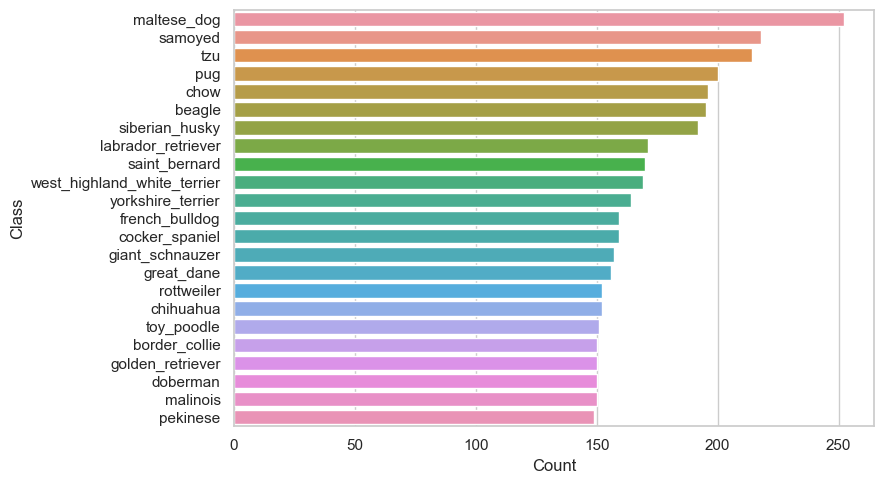

In [32]:
class_names = breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

#### DataLoader

In [33]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [34]:
train_dataset = dog_breed.DogBreedDataset(train_ds, train_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds, test_transform)

batch_size = 16

train_dl = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl = DataLoader(test_dataset, batch_size*2)

5


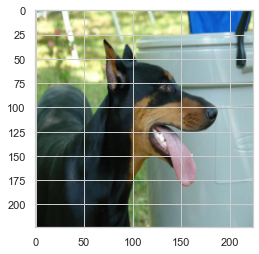

In [35]:
img, label = train_dataset[6]
print(label)
plt.imshow(img.permute(1,2,0))

#### Train loop

In [ ]:
models_list = ["resnet18", "alexnet", "vgg19bn", "densenet", "mobilenetv3"]
optimizers = {
    'Adam': torch.optim.Adam,
    'SGD': torch.optim.SGD,
}

time_log = {}  

for model_name in models_list:
    num_classes = len(all_breeds)
    for optimizer_name, optimizer_fn in optimizers.items():
        start_time = time.time()

        model = dog_breed.get_pretrained_model(model_name, num_classes)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optimizer_fn(model.parameters(), lr=0.001, weight_decay=1e-5)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        train, eval = dog_breed.train_and_test(model, model_name, train_dl, test_dl, criterion, optimizer, device, num_epochs=10, optimizer_name=optimizer_name.lower(), type='dog')

        optimizer_folder = optimizer_name.lower()
        os.makedirs(f"breed_models/dog/{optimizer_folder}", exist_ok=True)
        model_filename = f"breed_models/dog/{optimizer_folder}/{model_name}_best_model.pth"
        torch.save(model.state_dict(), model_filename)

        end_time = time.time()
        elapsed_time = end_time - start_time
        time_log[f"{model_name}_{optimizer_name}"] = elapsed_time

with open('training_times.txt', 'w') as file:
    for key, value in time_log.items():
        file.write(f"{key}: {value} seconds\n")


#### Results

In [2]:
model_accuracies_dict, model_test_accuracies_dict, model_losses_dict, last_true_labels, last_model_preds, model_names = dog_breed.load_the_results(type='dog', optimizer='adam')
model_accuracies_dict_sgd, model_test_accuracies_dict_sgd, model_losses_dict_sgd, last_true_labels_sgd, last_model_preds_sgd, model_names_sgd = dog_breed.load_the_results(type='dog', optimizer='sgd')

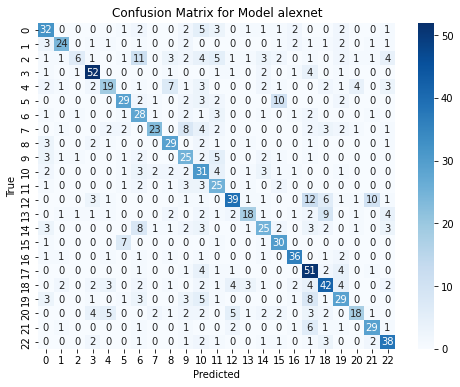

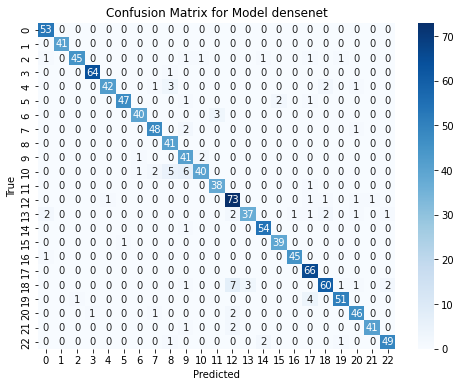

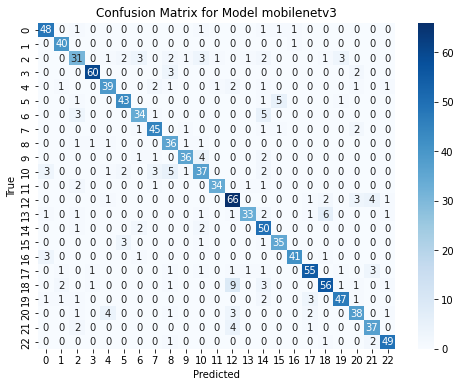

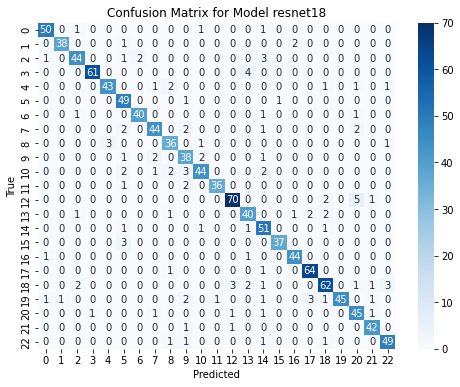

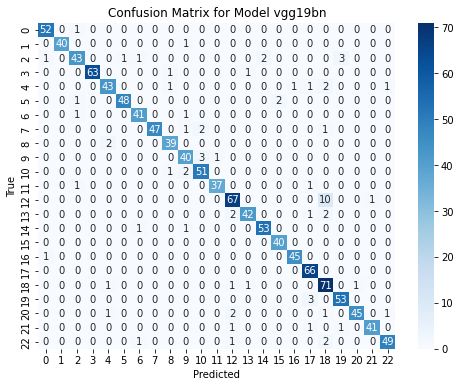

In [36]:
confusion_matrices = []

for true_labels, model_preds in zip(last_true_labels, last_model_preds):
    cm = confusion_matrix(true_labels, model_preds)
    confusion_matrices.append(cm)

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=np.unique(last_true_labels[i]), 
                yticklabels=np.unique(last_true_labels[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model {model_names[i]}')
    plt.show()


##### Train accuracies

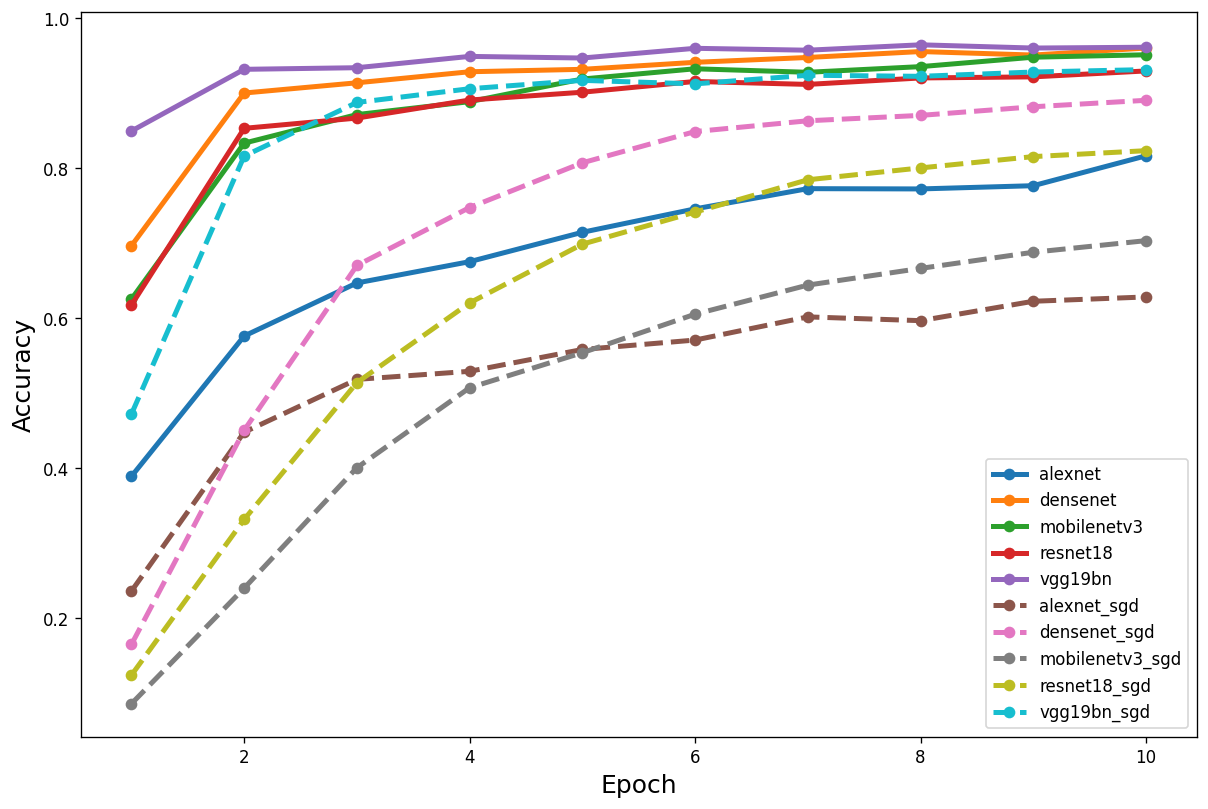

In [3]:
plt.figure(figsize=(12, 8), dpi=120)

for model, accuracies in model_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model, linewidth=3)

for model, accuracies in model_accuracies_dict_sgd.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='dashed', label=f'{model}_sgd', linewidth=3)
    
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

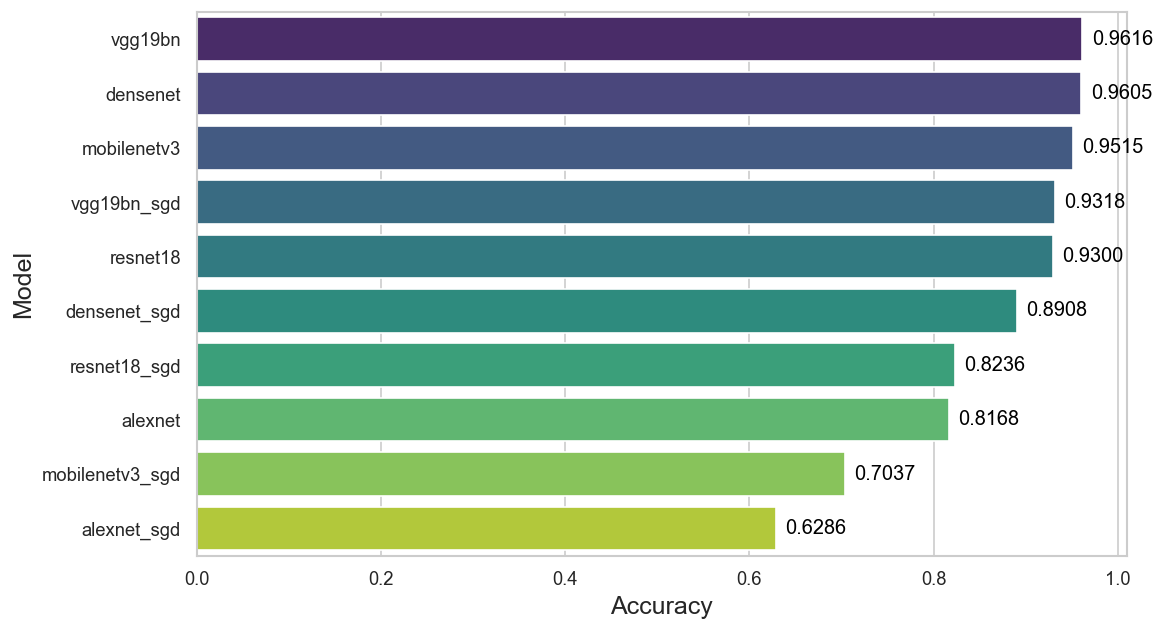

In [6]:
last_accuracies = [accuracies[-1] for accuracies in model_accuracies_dict.values()]
last_acc_sgd = [accuracies[-1] for accuracies in model_accuracies_dict_sgd.values()]

models_sgd = [
    model + '_sgd' for model in [
        'alexnet', 'densenet', 'mobilenetv3', 'resnet18', 'vgg19bn'
    ]
]

models = list(model_accuracies_dict.keys()) + [model + '_sgd' for model in model_accuracies_dict_sgd.keys()]

sorted_data = sorted(zip(last_accuracies + last_acc_sgd, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6), dpi=120)
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.xlabel('Accuracy', fontsize=15)
plt.ylabel('Model', fontsize=15)
plt.show()

In [11]:
models

['alexnet',
 'densenet',
 'mobilenetv3',
 'resnet18',
 'vgg19bn',
 'alexnet_sgd',
 'densenet_sgd',
 'mobilenetv3_sgd',
 'resnet18_sgd',
 'vgg19bn_sgd']

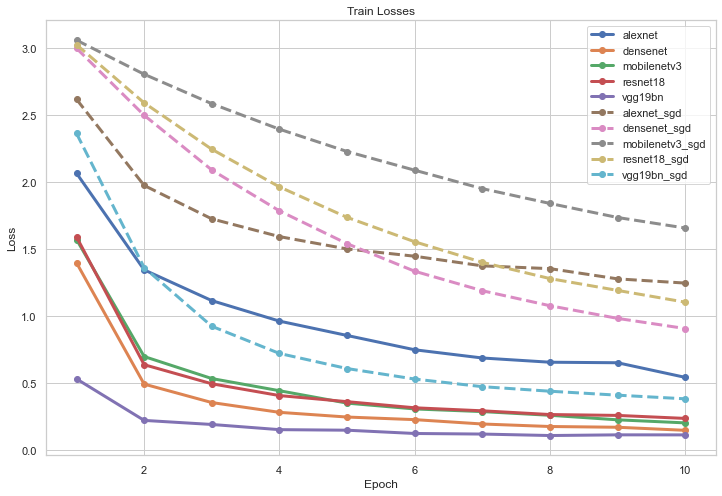

In [7]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_losses_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model, linewidth=3)

for model, accuracies in model_losses_dict_sgd.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='dashed', label=f'{model}_sgd', linewidth=3)

plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

##### Test accuracies

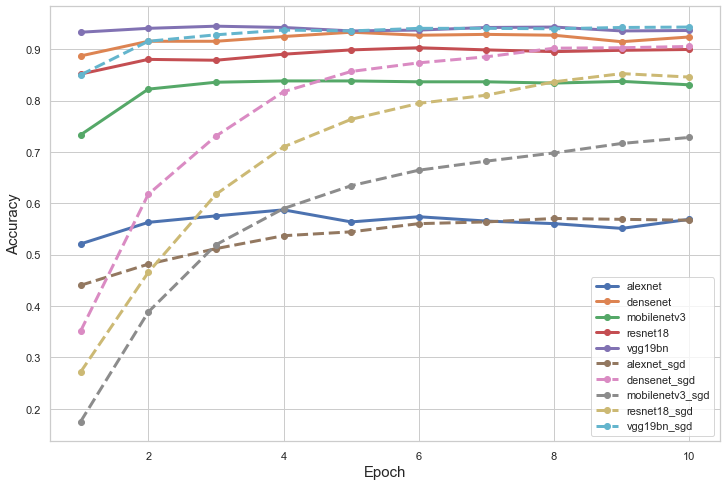

In [8]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_test_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model, linewidth=3)

for model, accuracies in model_test_accuracies_dict_sgd.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='dashed', label=f'{model}_sgd', linewidth=3)



plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

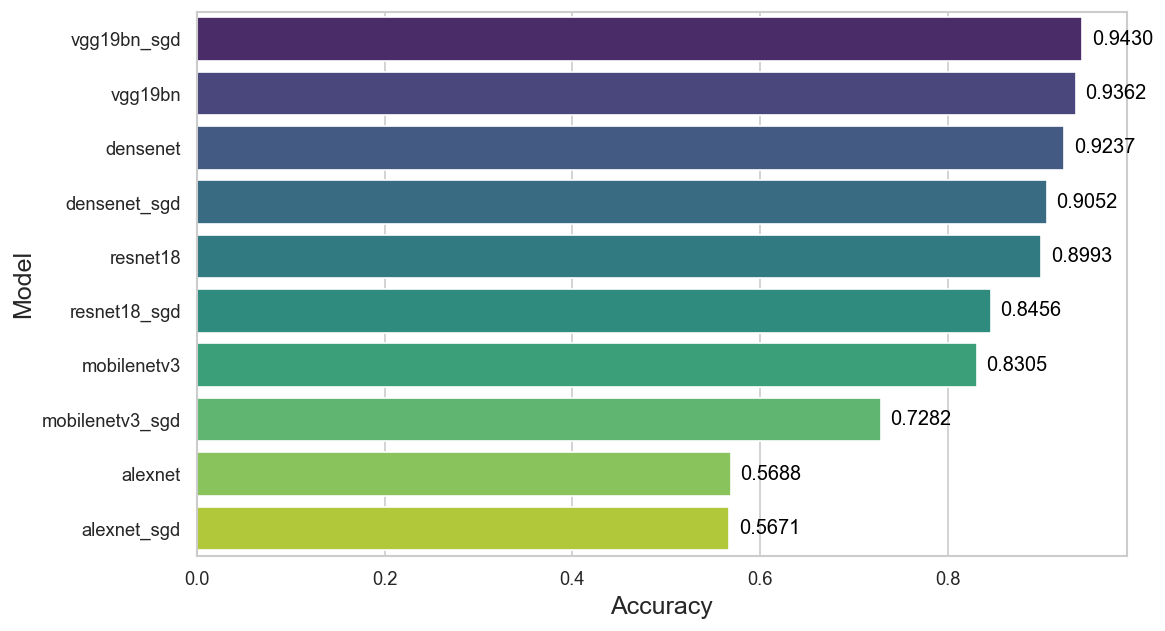

In [9]:
last_accuracies = [accuracies[-1] for accuracies in model_test_accuracies_dict.values()]
last_acc_sgd = [accuracies[-1] for accuracies in model_test_accuracies_dict_sgd.values()]

models_sgd = [
    model + '_sgd' for model in [
        'alexnet', 'densenet', 'mobilenetv3', 'resnet18', 'vgg19bn'
    ]
]

models = list(model_accuracies_dict.keys()) + [model + '_sgd' for model in model_accuracies_dict_sgd.keys()]

sorted_data = sorted(zip(last_accuracies + last_acc_sgd, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6), dpi=120)
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.xlabel('Accuracy', fontsize=15)
plt.ylabel('Model', fontsize=15)
plt.show()

#### Scrapped test dog dataset

In [81]:
specified_breeds = ['beagle', 'border_collie', 'chihuahua', 'chow',
                    'cocker_spaniel', 'doberman', 'french_bulldog', 'giant_schnauzer', 'golden_retriever',
                    'great_dane', 'labrador_retriever', 'malinois', 'maltese_dog', 'pekinese', 'pug', 'rottweiler',
                    'saint_bernard', 'samoyed', 'shih_tzu', 'siberian_husky', 'toy_poodle', 'west_highland_white_terrier', 'yorkshire_terrier']


In [82]:
results_directory = f'breed_models/dog/adam'
all_files = os.listdir(results_directory)
model_files = [file for file in all_files if file.endswith('.pth')]
model_names = [file.split('_')[0] for file in model_files]

In [83]:
results_directory_sgd = f'breed_models/dog/sgd'
all_files = os.listdir(results_directory_sgd)
model_files_sgd = [file for file in all_files if file.endswith('.pth')]
model_names_sgd  = [file.split('_')[0] for file in model_files_sgd]

In [25]:
source_folder = 'breed_dataset/dog/'
target_folder = 'filtered_dataset/dog/test'

if not os.path.exists(target_folder):
    os.makedirs(target_folder)

dataset = ImageFolder(root=source_folder)

for idx, (image_path, label) in enumerate(dataset.imgs):
    breed_name = dataset.classes[label].split('-', 1)[-1].lower()
    if breed_name in specified_breeds:
        breed_folder = os.path.join(target_folder, breed_name)
        if not os.path.exists(breed_folder):
            os.makedirs(breed_folder)
        shutil.copy(image_path, breed_folder)

  0%|          | 0/88 [00:00<?, ?it/s]

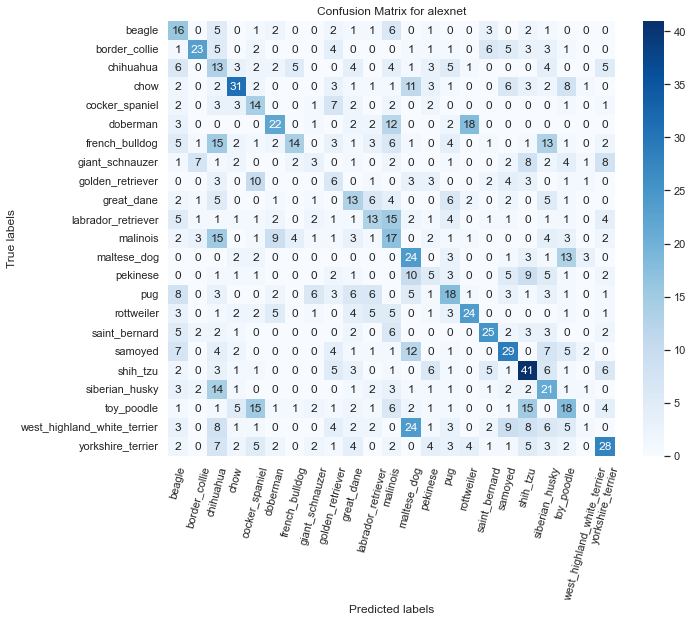

Adam Optimizer - Model: alexnet, Accuracy: 29.99%


  0%|          | 0/88 [00:00<?, ?it/s]

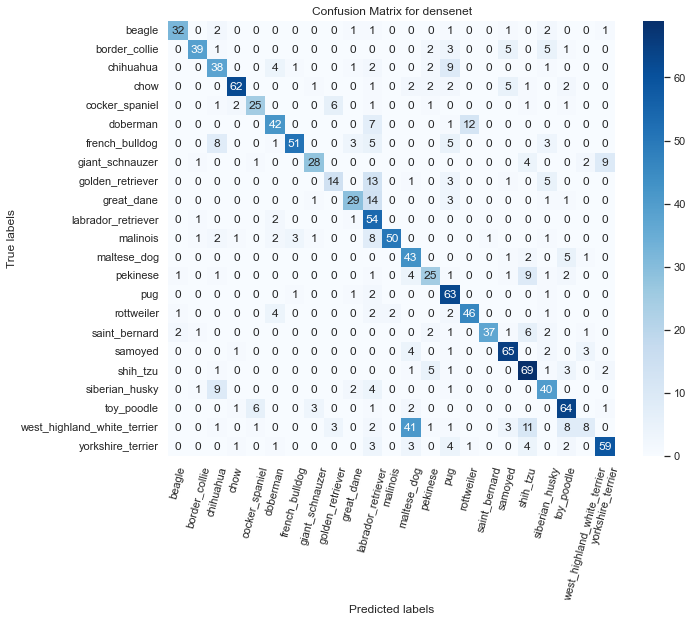

Adam Optimizer - Model: densenet, Accuracy: 70.37%


  0%|          | 0/88 [00:00<?, ?it/s]

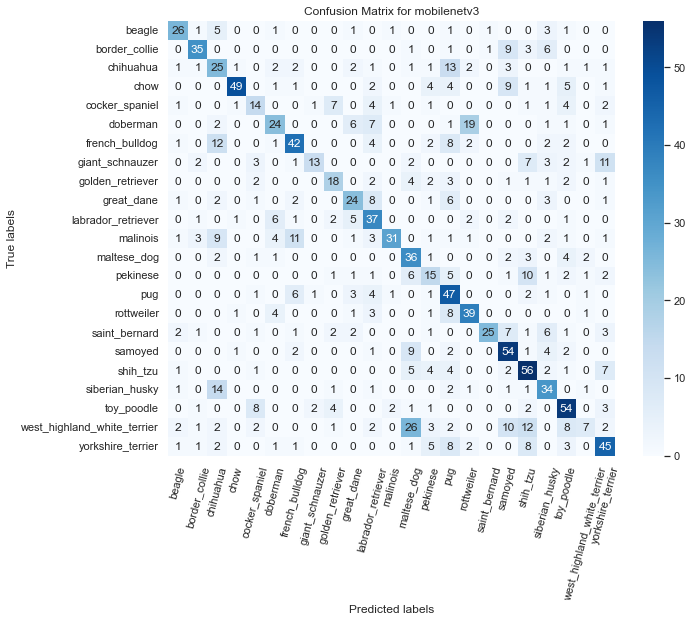

Adam Optimizer - Model: mobilenetv3, Accuracy: 53.69%


  0%|          | 0/88 [00:00<?, ?it/s]

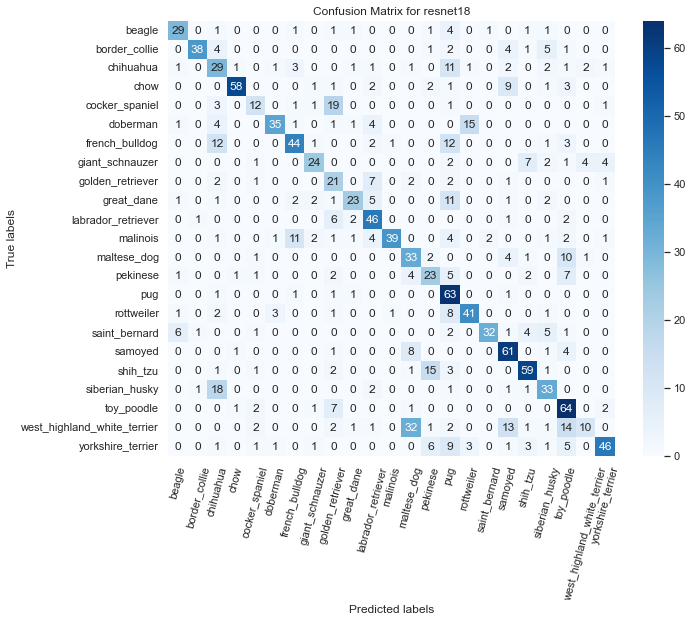

Adam Optimizer - Model: resnet18, Accuracy: 61.78%


  0%|          | 0/88 [00:00<?, ?it/s]

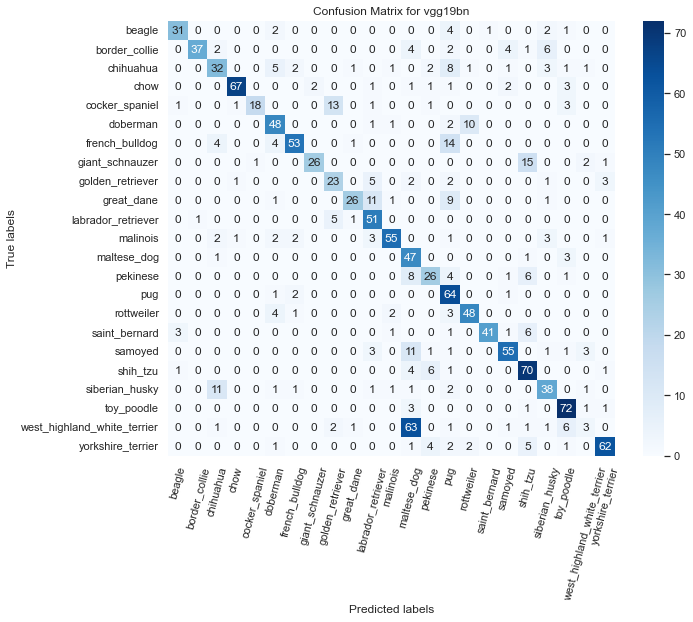

Adam Optimizer - Model: vgg19bn, Accuracy: 71.08%


  0%|          | 0/88 [00:00<?, ?it/s]

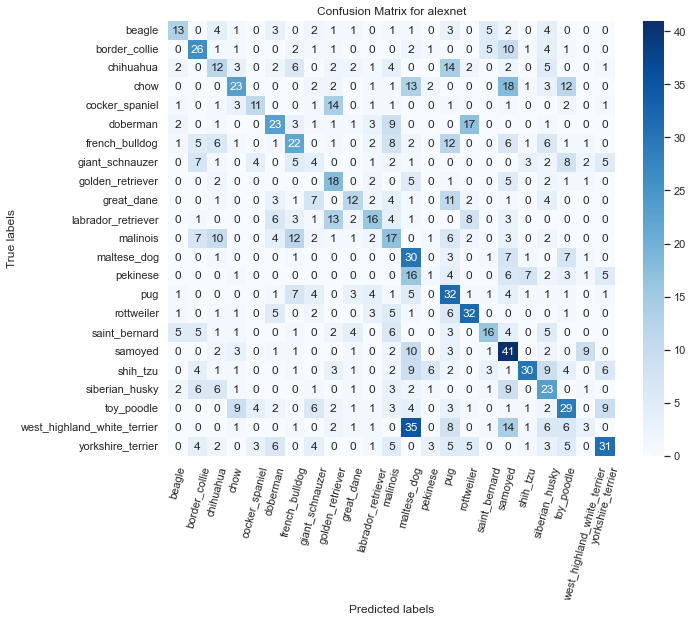

SGD Optimizer - Model: alexnet, Accuracy: 33.29%


  0%|          | 0/88 [00:00<?, ?it/s]

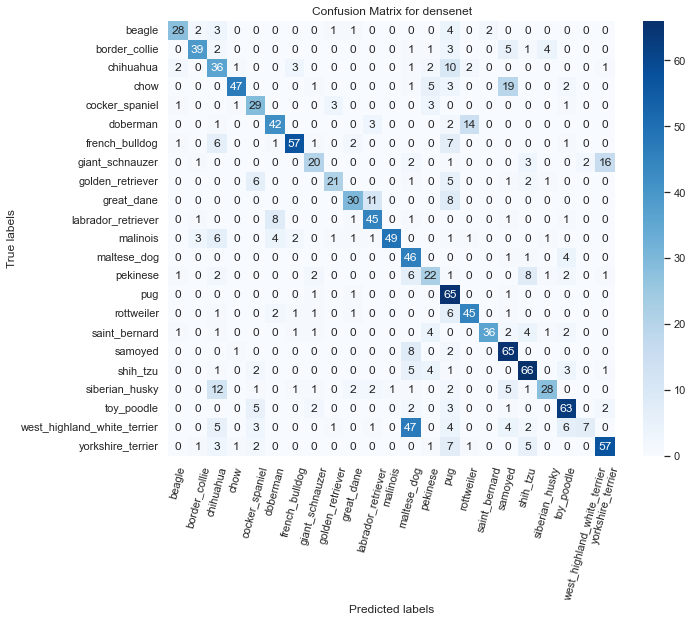

SGD Optimizer - Model: densenet, Accuracy: 67.50%


  0%|          | 0/88 [00:00<?, ?it/s]

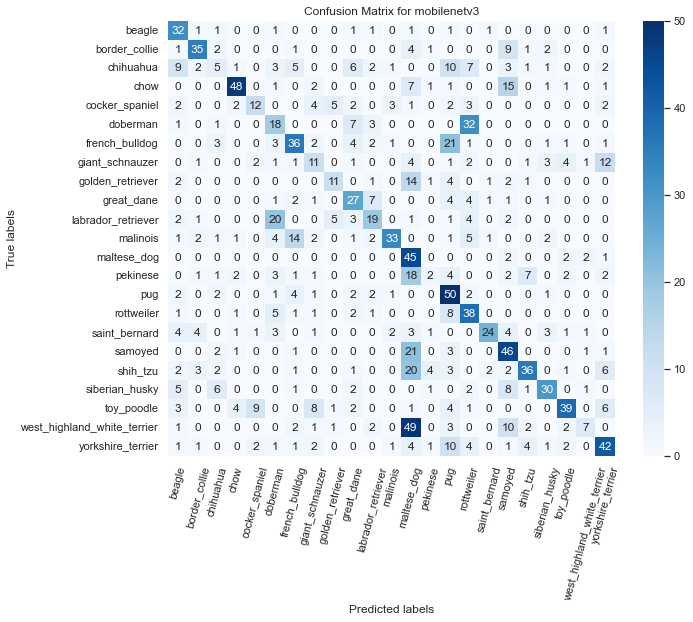

SGD Optimizer - Model: mobilenetv3, Accuracy: 46.24%


  0%|          | 0/88 [00:00<?, ?it/s]

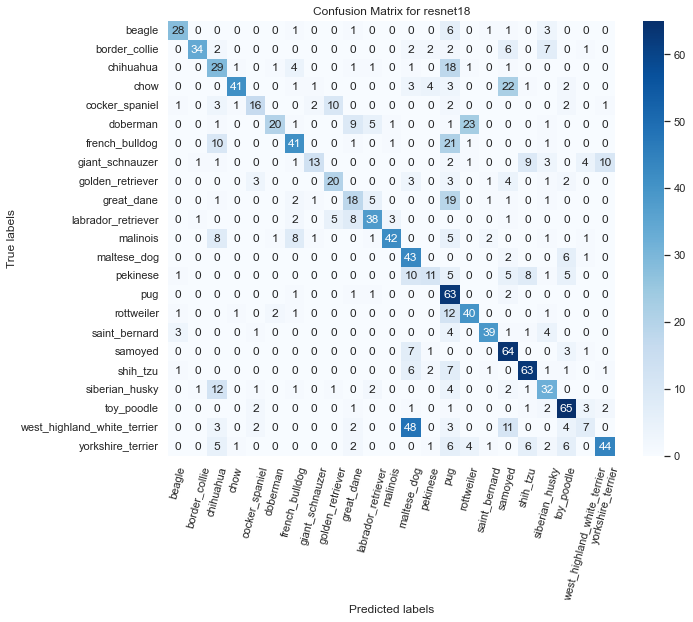

SGD Optimizer - Model: resnet18, Accuracy: 58.05%


  0%|          | 0/88 [00:00<?, ?it/s]

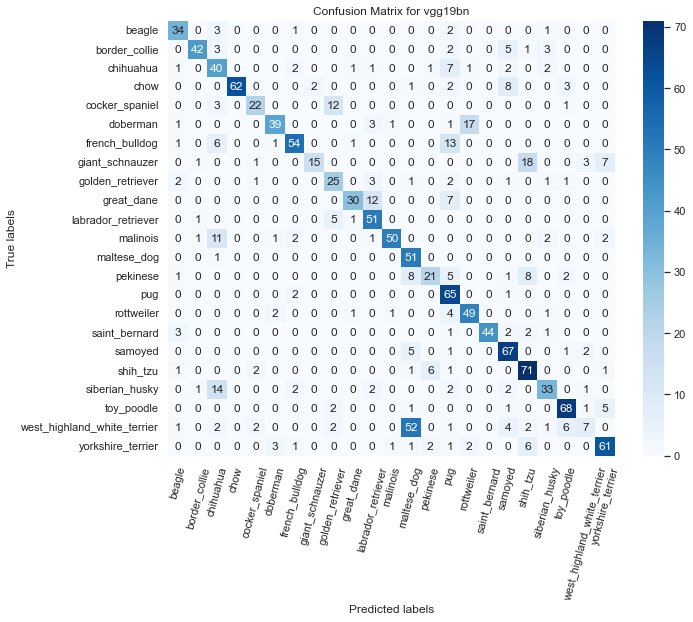

SGD Optimizer - Model: vgg19bn, Accuracy: 71.65%


In [85]:
test_data_scrap_cat = ImageFolder('filtered_dataset/dog/test')
# resize the images to 224,224. (it does not matter actually since models have adaptive pooling layer)
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])
# store the accuracies
accuracies_scrap = {}
batch_size = 8
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# adam
for model_name in model_names:
    # load the model
    state_dict = torch.load(f"breed_models/dog/adam/{model_name}_best_model.pth")
    model = dog_breed.get_pretrained_model(model_name, len(specified_breeds))
    model.load_state_dict(state_dict)
    model.to(device)
    # load the test data
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size * 2)
    # plot the confusion
    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, specified_breeds, model_name)
    # print the accuracy as well
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[model_name] = accuracy
    print(f"Adam Optimizer - Model: {model_name}, Accuracy: {accuracy * 100:.2f}%")

# sgd
for model_name_sgd in model_names_sgd:
    # load the model
    state_dict_sgd = torch.load(f"breed_models/dog/sgd/{model_name_sgd}_best_model.pth")
    model_sgd = dog_breed.get_pretrained_model(model_name_sgd, len(specified_breeds))
    model_sgd.load_state_dict(state_dict_sgd)
    model_sgd.to(device)
    # load the test data
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size * 2)
    # plot the confusion
    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model_sgd, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, specified_breeds, model_name_sgd)
    # print the accuracy as well
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[f'{model_name_sgd}_sgd'] = accuracy
    print(f"SGD Optimizer - Model: {model_name_sgd}, Accuracy: {accuracy * 100:.2f}%")



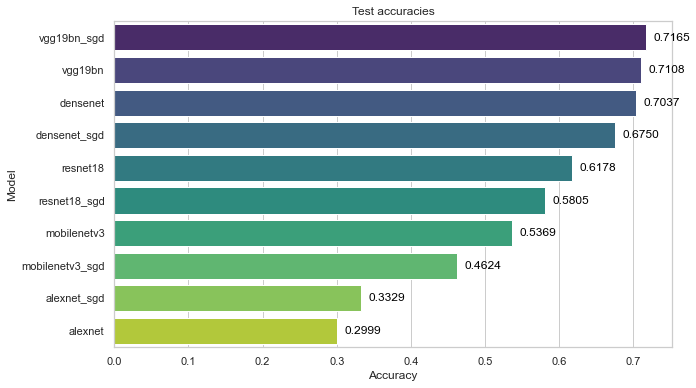

In [86]:
last_accuracies = [accuracies for accuracies in accuracies_scrap.values()]
models = list(accuracies_scrap.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()


## Cat

### Training

#### Data Loading, Transformation and creating the Dataset

In [14]:
class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

data_dir = 'oxford-iiit-pet/images/images/'

output_dir = 'filtered_dataset/cat/train/'

if not os.path.exists(output_dir):
    os.makedirs(output_dir)

for class_name in class_names:
    class_dir = os.path.join(output_dir, class_name)
    if not os.path.exists(class_dir):
        os.makedirs(class_dir)

for root, dirs, files in os.walk(data_dir):
    for file in files:
        if file.endswith('.jpg'):
            for class_name in class_names:
                if class_name.lower() in file.lower():
                    src_path = os.path.join(root, file)
                    dst_path = os.path.join(output_dir, class_name, file)
                    shutil.copy(src_path, dst_path)
                    break 


In [15]:
dataset = ImageFolder('filtered_dataset/cat/train/')

In [16]:
all_breeds = dataset.classes

print("Total number of breeds:", len(all_breeds))
print("List of all breeds:")
print(all_breeds)

Total number of breeds: 10
List of all breeds:
['abyssinian', 'bengal', 'bombay', 'british_shorthair', 'maine_coon', 'persian', 'ragdoll', 'russian_blue', 'siamese', 'sphynx']


In [17]:
test_pct = 0.3
test_size = int(len(dataset)*test_pct)
dataset_size = len(dataset) - test_size
train_size = dataset_size

train_size,  test_size

(1400, 600)

In [18]:
train_ds_cat, test_ds_cat = random_split(dataset, [train_size, test_size])
len(train_ds_cat), len(test_ds_cat)

(1400, 600)

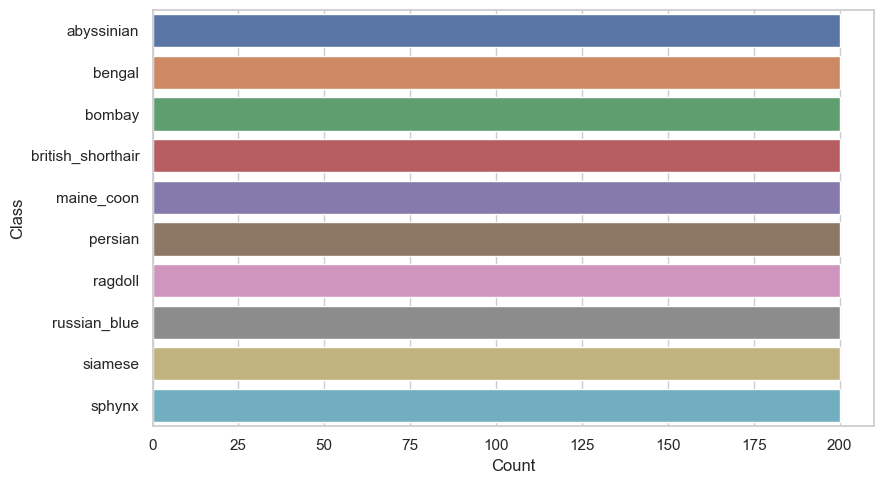

In [19]:
class_names = all_breeds
class_count = [dataset.targets.count(i) for i in range(len(class_names))]
df = pd.DataFrame({"Class": class_names, "Count": class_count}).sort_values(by='Count', ascending=False)

plt.figure(figsize=(9,5), dpi=100)
sns.barplot(x="Count", y="Class", data=df)
plt.tight_layout()
plt.show()

In [20]:
train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
])

test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])

In [21]:
train_dataset = dog_breed.DogBreedDataset(train_ds_cat, train_transform)
test_dataset = dog_breed.DogBreedDataset(test_ds_cat, test_transform)

batch_size = 16

train_dl_cat = DataLoader(train_dataset, batch_size, shuffle=True)
test_dl_cat = DataLoader(test_dataset, batch_size*2)

1


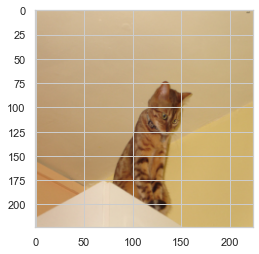

In [22]:
img, label = train_dataset[11]
print(label)
plt.imshow(img.permute(1,2,0))

#### Training

In [120]:
models_list = ["resnet18", "alexnet", "vgg19bn", "densenet", "mobilenetv3"]
optimizers = {
    'SGD': torch.optim.SGD,
}

time_log = {}  

for model_name in models_list:
    num_classes = len(all_breeds)
    for optimizer_name, optimizer_fn in optimizers.items():
        start_time = time.time()

        model = dog_breed.get_pretrained_model(model_name, num_classes)

        criterion = torch.nn.CrossEntropyLoss()
        optimizer = optimizer_fn(model.parameters(), lr=0.001, weight_decay=1e-5)
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        model.to(device)

        train, eval = dog_breed.train_and_test(model, model_name, train_dl_cat, test_dl_cat, criterion, optimizer, device, num_epochs=10, optimizer_name=optimizer_name.lower(), type='cat')

        optimizer_folder = optimizer_name.lower()
        os.makedirs(f"breed_models/cat/{optimizer_folder}", exist_ok=True)
        model_filename = f"breed_models/cat/{optimizer_folder}/{model_name}_best_model.pth"
        torch.save(model.state_dict(), model_filename)

        end_time = time.time()
        elapsed_time = end_time - start_time
        time_log[f"{model_name}_{optimizer_name}"] = elapsed_time

with open('training_times.txt', 'w') as file:
    for key, value in time_log.items():
        file.write(f"{key}: {value} seconds\n")


Epoch 1/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 2.2161 Acc: 0.1814
Test Loss: 2.0511 Acc: 0.3367
Epoch 2/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.9419 Acc: 0.3907
Test Loss: 1.8017 Acc: 0.5033
Epoch 3/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.7124 Acc: 0.5500
Test Loss: 1.5936 Acc: 0.6317
Epoch 4/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.5187 Acc: 0.6686
Test Loss: 1.4223 Acc: 0.7217
Epoch 5/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.3807 Acc: 0.7250
Test Loss: 1.2857 Acc: 0.7483
Epoch 6/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.2412 Acc: 0.7636
Test Loss: 1.1893 Acc: 0.7800
Epoch 7/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.1589 Acc: 0.7821
Test Loss: 1.0832 Acc: 0.7933
Epoch 8/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.0716 Acc: 0.8150
Test Loss: 1.0314 Acc: 0.8117
Epoch 9/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.0003 Acc: 0.8150
Test Loss: 0.9673 Acc: 0.8167
Epoch 10/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.9326 Acc: 0.8393
Test Loss: 0.9032 Acc: 0.8200
Epoch 1/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.8341 Acc: 0.3657
Test Loss: 1.4935 Acc: 0.4717
Epoch 2/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.3282 Acc: 0.5786
Test Loss: 1.2352 Acc: 0.6017
Epoch 3/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.1467 Acc: 0.6271
Test Loss: 1.1299 Acc: 0.5950
Epoch 4/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.0444 Acc: 0.6607
Test Loss: 1.0674 Acc: 0.6367
Epoch 5/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.9825 Acc: 0.6764
Test Loss: 1.0247 Acc: 0.6417
Epoch 6/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.9154 Acc: 0.7014
Test Loss: 1.0124 Acc: 0.6267
Epoch 7/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8773 Acc: 0.7157
Test Loss: 0.9899 Acc: 0.6317
Epoch 8/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8536 Acc: 0.7186
Test Loss: 0.9530 Acc: 0.6467
Epoch 9/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8235 Acc: 0.7314
Test Loss: 0.9510 Acc: 0.6500
Epoch 10/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7971 Acc: 0.7343
Test Loss: 0.9483 Acc: 0.6500
Epoch 1/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 2.0023 Acc: 0.3579
Test Loss: 1.5972 Acc: 0.7417
Epoch 2/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4453 Acc: 0.6771
Test Loss: 1.1890 Acc: 0.8283
Epoch 3/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.1203 Acc: 0.7943
Test Loss: 0.9569 Acc: 0.8667
Epoch 4/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.9542 Acc: 0.8171
Test Loss: 0.8236 Acc: 0.8817
Epoch 5/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8314 Acc: 0.8264
Test Loss: 0.7278 Acc: 0.8750
Epoch 6/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7452 Acc: 0.8579
Test Loss: 0.6712 Acc: 0.8717
Epoch 7/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.7029 Acc: 0.8514
Test Loss: 0.6190 Acc: 0.8717
Epoch 8/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.6387 Acc: 0.8507
Test Loss: 0.5631 Acc: 0.8817
Epoch 9/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5961 Acc: 0.8793
Test Loss: 0.5320 Acc: 0.8833
Epoch 10/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.5664 Acc: 0.8750
Test Loss: 0.5214 Acc: 0.8783
Epoch 1/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 2.2077 Acc: 0.2293
Test Loss: 2.0247 Acc: 0.4083
Epoch 2/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.9075 Acc: 0.5036
Test Loss: 1.7566 Acc: 0.6217
Epoch 3/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.6764 Acc: 0.6421
Test Loss: 1.5310 Acc: 0.7367
Epoch 4/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4715 Acc: 0.7514
Test Loss: 1.3650 Acc: 0.7767
Epoch 5/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.3131 Acc: 0.7971
Test Loss: 1.2227 Acc: 0.8067
Epoch 6/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.2069 Acc: 0.8136
Test Loss: 1.0915 Acc: 0.8633
Epoch 7/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.0890 Acc: 0.8407
Test Loss: 1.0106 Acc: 0.8733
Epoch 8/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.0040 Acc: 0.8571
Test Loss: 0.9275 Acc: 0.8867
Epoch 9/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.9337 Acc: 0.8600
Test Loss: 0.8734 Acc: 0.8817
Epoch 10/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 0.8640 Acc: 0.8779
Test Loss: 0.8099 Acc: 0.8950
Epoch 1/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 2.2527 Acc: 0.1786
Test Loss: 2.1135 Acc: 0.2733
Epoch 2/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 2.0334 Acc: 0.3636
Test Loss: 1.9614 Acc: 0.4283
Epoch 3/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.8552 Acc: 0.5207
Test Loss: 1.7998 Acc: 0.5417
Epoch 4/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.7092 Acc: 0.6071
Test Loss: 1.6384 Acc: 0.6400
Epoch 5/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.5904 Acc: 0.6643
Test Loss: 1.5101 Acc: 0.6817
Epoch 6/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.4767 Acc: 0.7057
Test Loss: 1.4061 Acc: 0.7217
Epoch 7/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.3671 Acc: 0.7286
Test Loss: 1.3193 Acc: 0.7383
Epoch 8/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.2973 Acc: 0.7493
Test Loss: 1.2441 Acc: 0.7583
Epoch 9/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.2207 Acc: 0.7729
Test Loss: 1.1777 Acc: 0.7683
Epoch 10/10


  0%|          | 0/88 [00:00<?, ?it/s]

Train Loss: 1.1429 Acc: 0.7986
Test Loss: 1.1213 Acc: 0.7783


### Result Analysis

In [2]:
model_accuracies_dict, model_test_accuracies_dict, model_losses_dict, last_true_labels, last_model_preds, model_names = dog_breed.load_the_results(type='cat')
model_accuracies_dict_sgd, model_test_accuracies_dict_sgd, model_losses_dict_sgd, last_true_labels_sgd, last_model_preds_sgd, model_names_sgd = dog_breed.load_the_results_sgd(type='cat')

#### Confusion Matrices

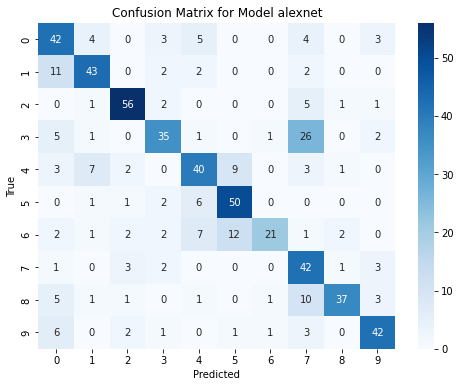

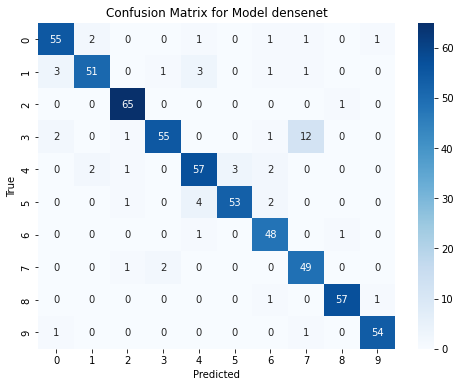

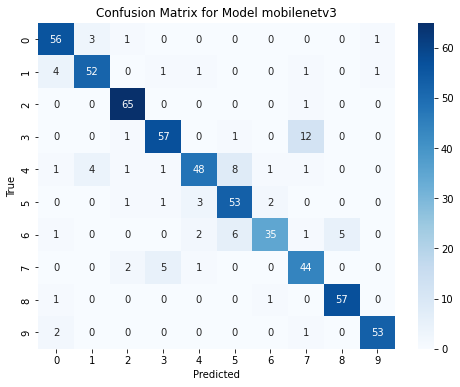

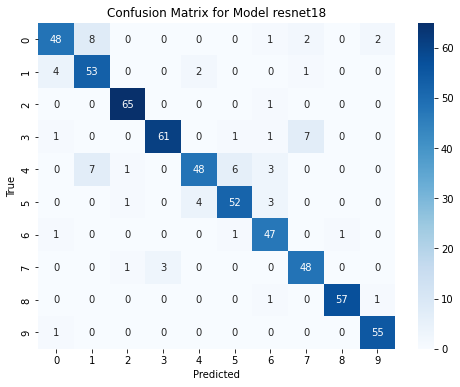

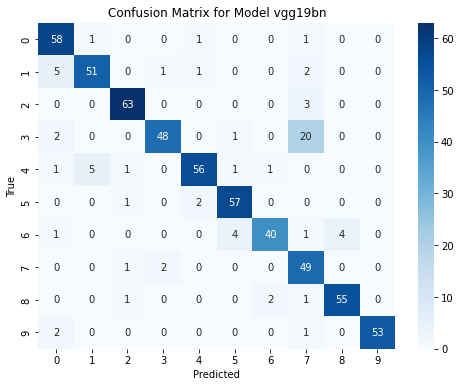

In [3]:
confusion_matrices = []

for true_labels, model_preds in zip(last_true_labels, last_model_preds):
    cm = confusion_matrix(true_labels, model_preds)
    confusion_matrices.append(cm)

for i, cm in enumerate(confusion_matrices):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', 
                xticklabels=np.unique(last_true_labels[i]), 
                yticklabels=np.unique(last_true_labels[i]))
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title(f'Confusion Matrix for Model {model_names[i]}')
    plt.show()


#### Accuracies

##### Train Accuracies

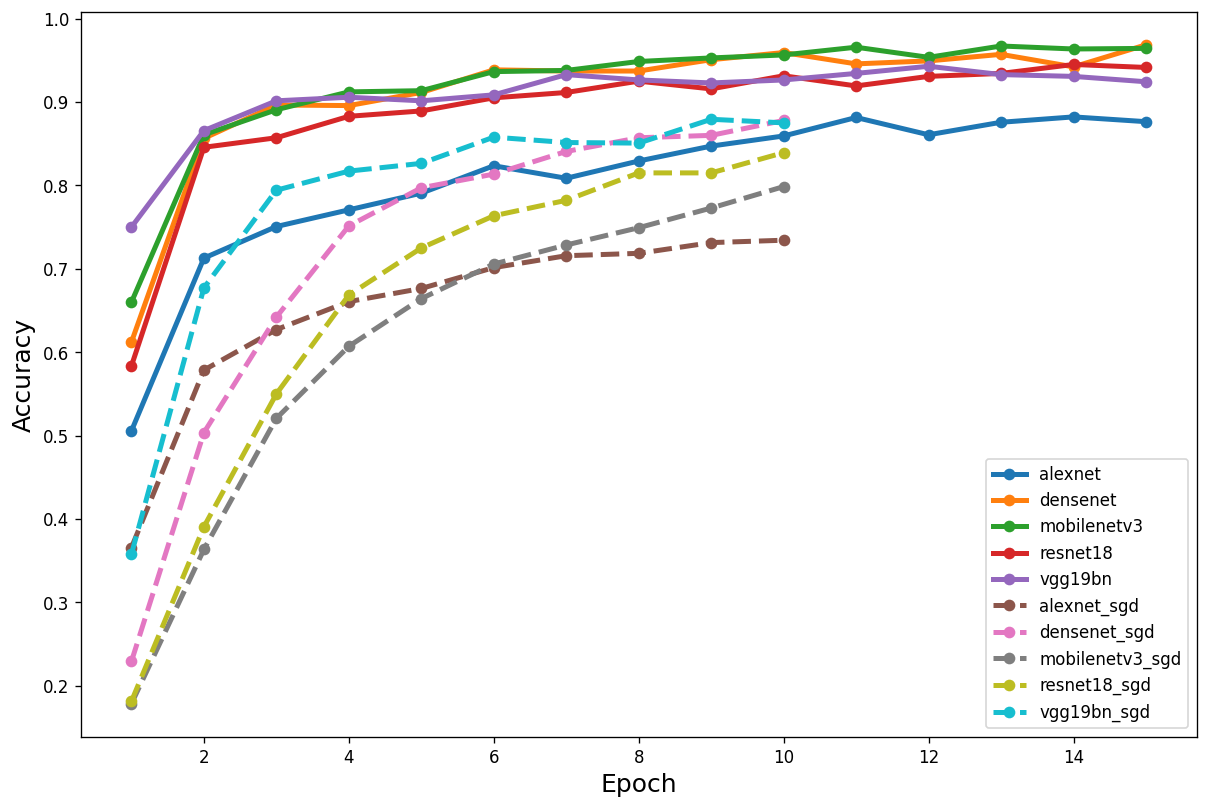

In [4]:
plt.figure(figsize=(12, 8), dpi=120)

for model, accuracies in model_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model, linewidth=3)

for model, accuracies in model_accuracies_dict_sgd.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='dashed', label=f'{model}_sgd', linewidth=3)
    
plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

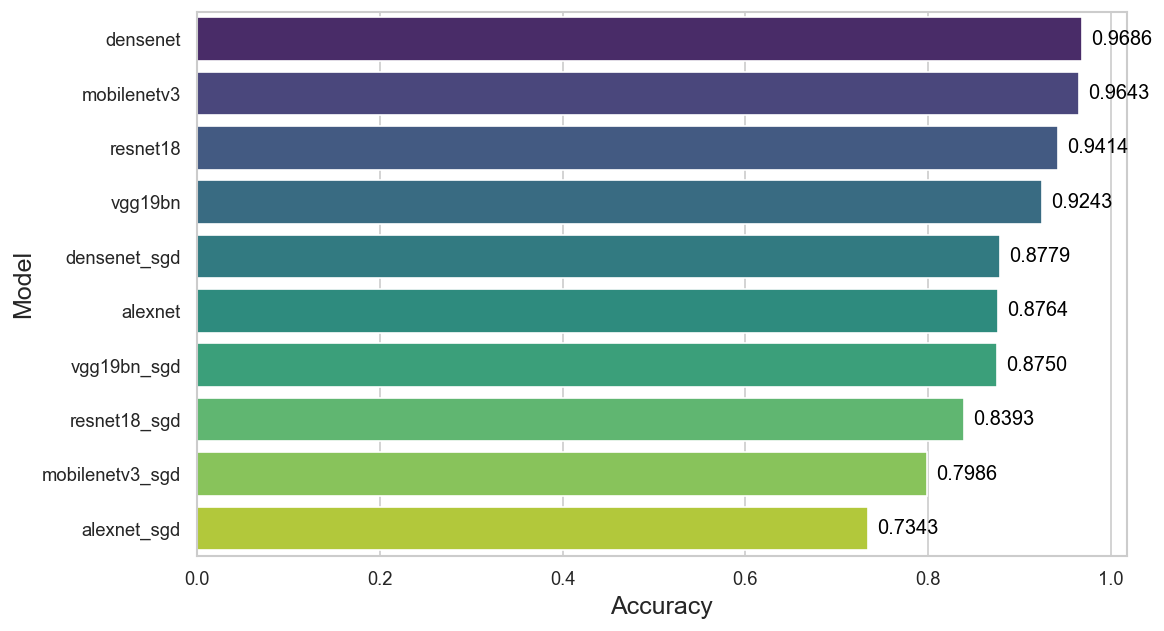

In [5]:
last_accuracies = [accuracies[-1] for accuracies in model_accuracies_dict.values()]
last_acc_sgd = [accuracies[-1] for accuracies in model_accuracies_dict_sgd.values()]

models_sgd = [
    model + '_sgd' for model in [
        'alexnet', 'densenet', 'mobilenetv3', 'resnet18', 'vgg19bn'
    ]
]

models = list(model_accuracies_dict.keys()) + [model + '_sgd' for model in model_accuracies_dict_sgd.keys()]

sorted_data = sorted(zip(last_accuracies + last_acc_sgd, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6), dpi=120)
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.xlabel('Accuracy', fontsize=15)
plt.ylabel('Model', fontsize=15)
plt.show()

##### Test Accuracies

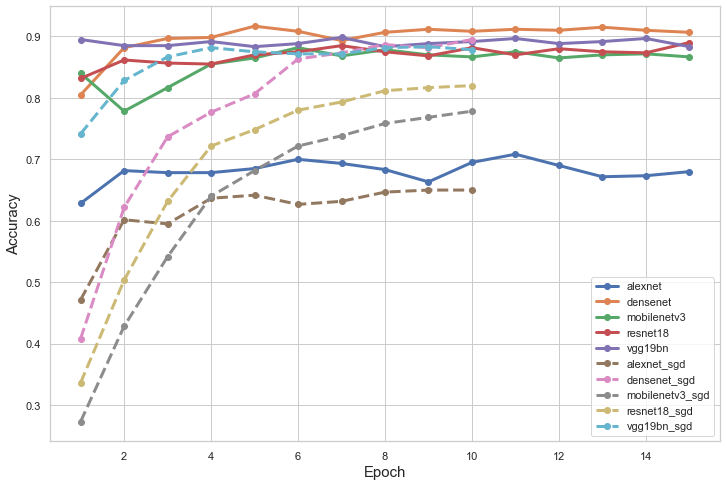

In [6]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_test_accuracies_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model, linewidth=3)

for model, accuracies in model_test_accuracies_dict_sgd.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='dashed', label=f'{model}_sgd', linewidth=3)



plt.xlabel('Epoch', fontsize=15)
plt.ylabel('Accuracy', fontsize=15)
plt.legend()
plt.show()

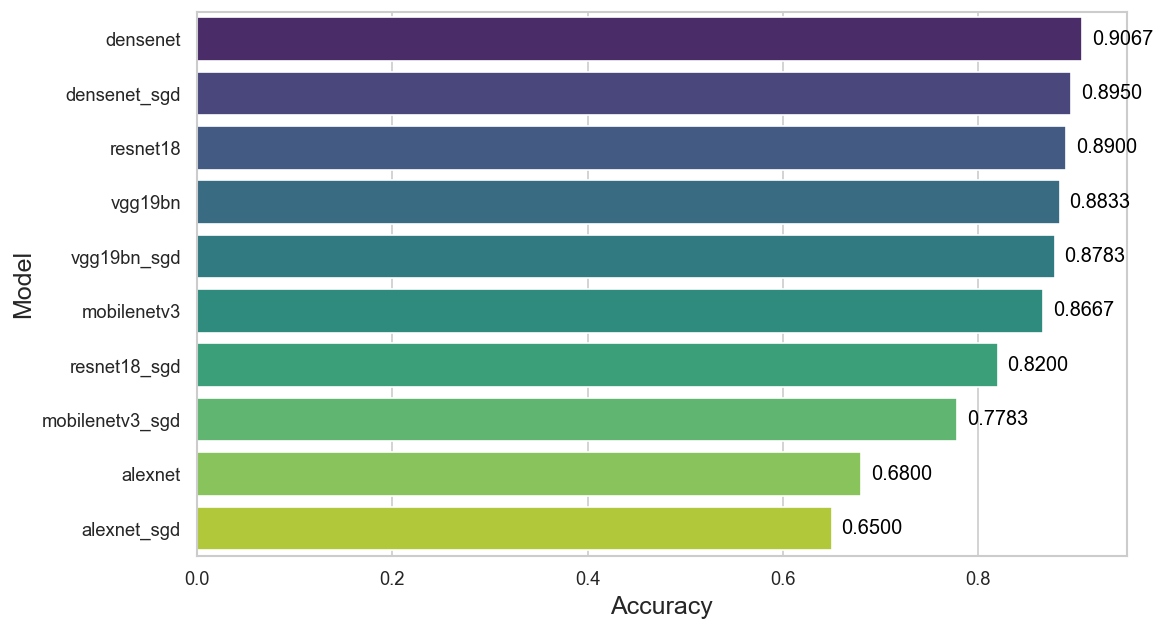

In [7]:
last_accuracies = [accuracies[-1] for accuracies in model_test_accuracies_dict.values()]
last_acc_sgd = [accuracies[-1] for accuracies in model_test_accuracies_dict_sgd.values()]

models_sgd = [
    model + '_sgd' for model in [
        'alexnet', 'densenet', 'mobilenetv3', 'resnet18', 'vgg19bn'
    ]
]

models = list(model_accuracies_dict.keys()) + [model + '_sgd' for model in model_accuracies_dict_sgd.keys()]

sorted_data = sorted(zip(last_accuracies + last_acc_sgd, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6), dpi=120)
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.xlabel('Accuracy', fontsize=15)
plt.ylabel('Model', fontsize=15)
plt.show()

##### Train loss

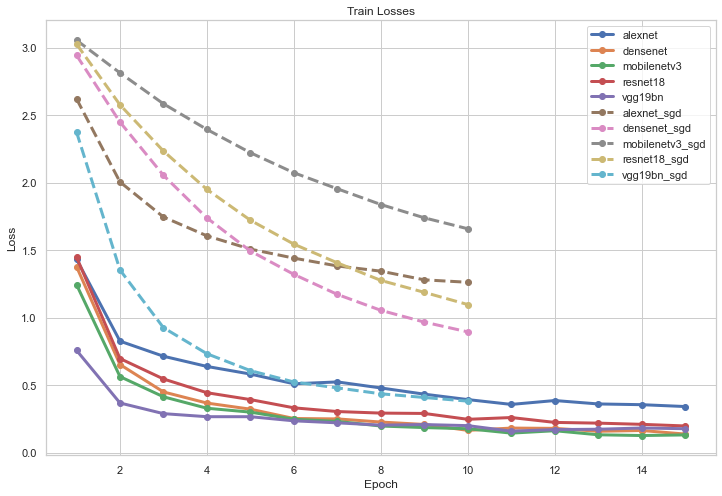

In [93]:
plt.figure(figsize=(12, 8))

for model, accuracies in model_losses_dict.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', label=model, linewidth=3)

for model, accuracies in model_losses_dict_sgd.items():
    plt.plot(range(1, len(accuracies) + 1), accuracies, marker='o', linestyle='dashed', label=f'{model}_sgd', linewidth=3)

plt.title('Train Losses')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

#### Test on scrapped dataset cat

In [8]:
class_names = [
    'abyssinian', 'bengal', 'bombay',
    'british_shorthair', 'maine_coon', 'persian',
    'ragdoll', 'russian_blue', 'siamese', 'sphynx'
]

In [9]:
results_directory = f'breed_models/cat/adam'
all_files = os.listdir(results_directory)
model_files = [file for file in all_files if file.endswith('.pth')]
model_names = [file.split('_')[0] for file in model_files]

In [10]:
results_directory_sgd = f'breed_models/cat/sgd'
all_files = os.listdir(results_directory_sgd)
model_files_sgd = [file for file in all_files if file.endswith('.pth')]
model_names_sgd  = [file.split('_')[0] for file in model_files_sgd]

  0%|          | 0/55 [00:00<?, ?it/s]

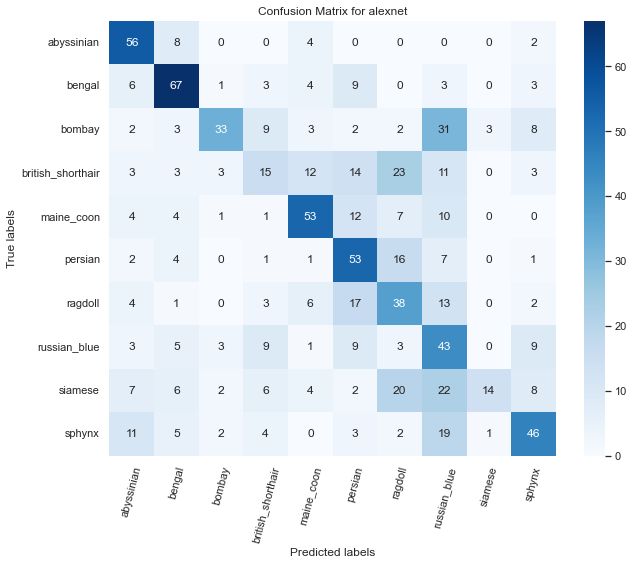

Adam Optimizer - Model: alexnet, Accuracy: 47.55%


  0%|          | 0/55 [00:00<?, ?it/s]

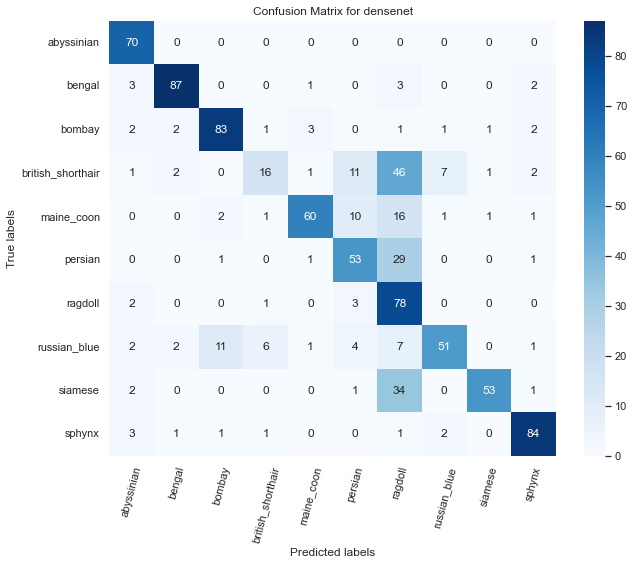

Adam Optimizer - Model: densenet, Accuracy: 72.24%


  0%|          | 0/55 [00:00<?, ?it/s]

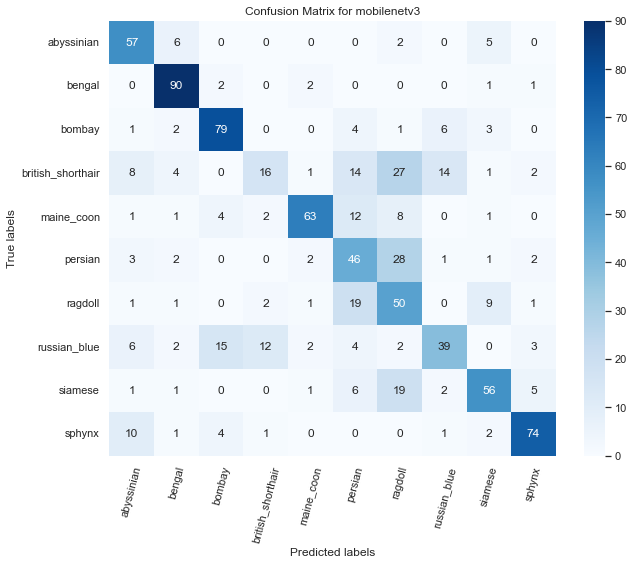

Adam Optimizer - Model: mobilenetv3, Accuracy: 64.85%


  0%|          | 0/55 [00:00<?, ?it/s]

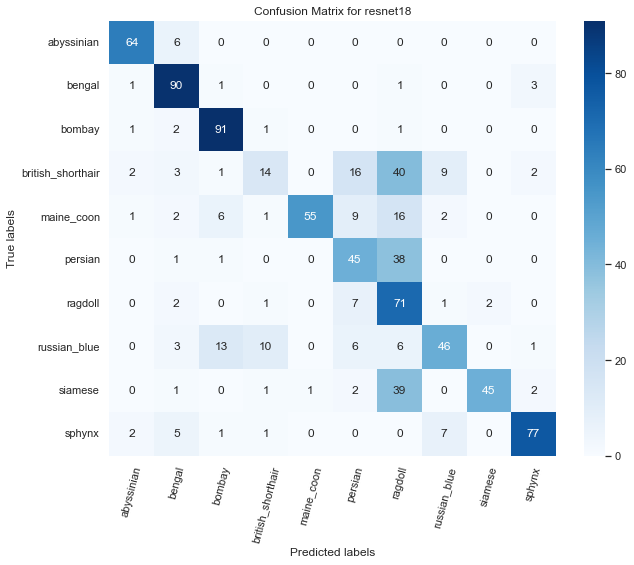

Adam Optimizer - Model: resnet18, Accuracy: 68.03%


  0%|          | 0/55 [00:00<?, ?it/s]

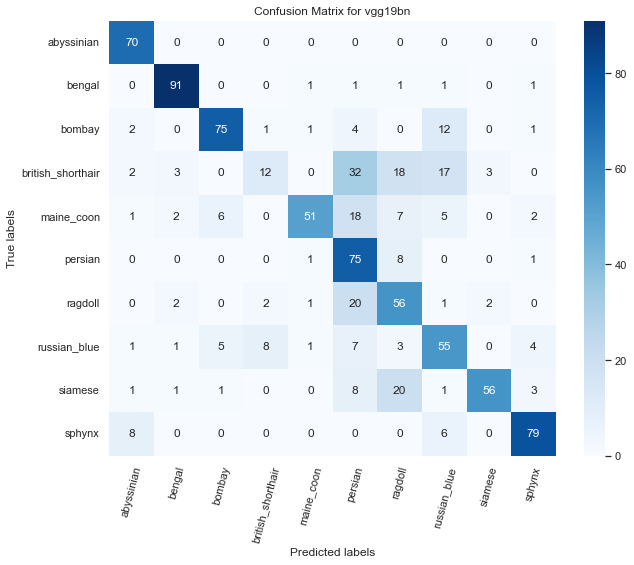

Adam Optimizer - Model: vgg19bn, Accuracy: 70.53%


  0%|          | 0/55 [00:00<?, ?it/s]

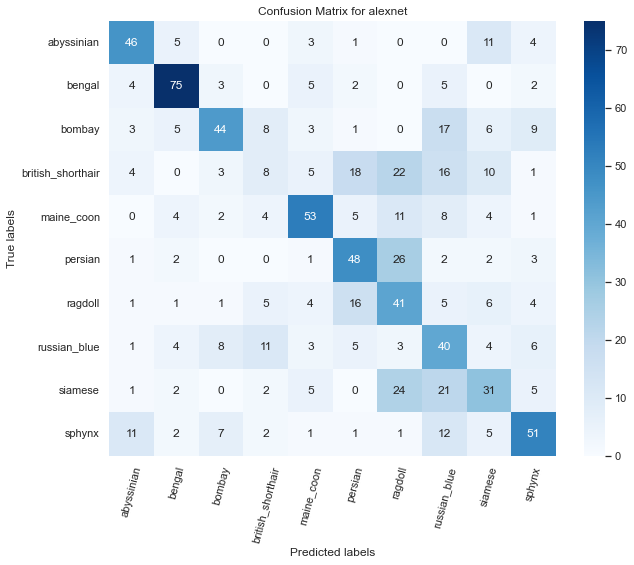

SGD Optimizer - Model: alexnet, Accuracy: 49.72%


  0%|          | 0/55 [00:00<?, ?it/s]

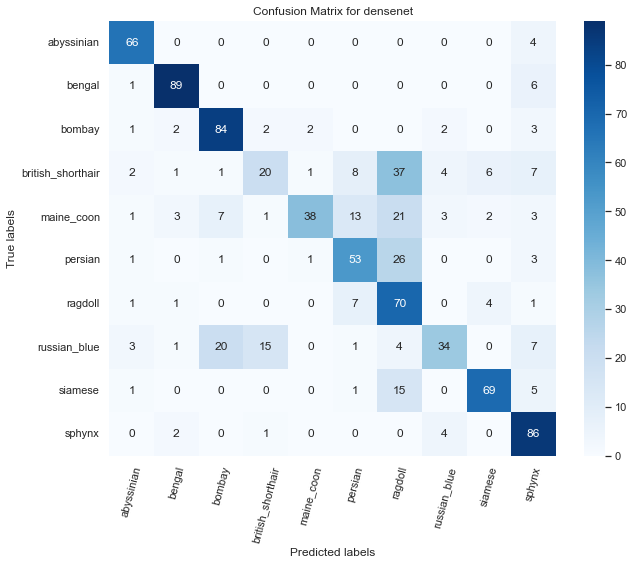

SGD Optimizer - Model: densenet, Accuracy: 69.28%


  0%|          | 0/55 [00:00<?, ?it/s]

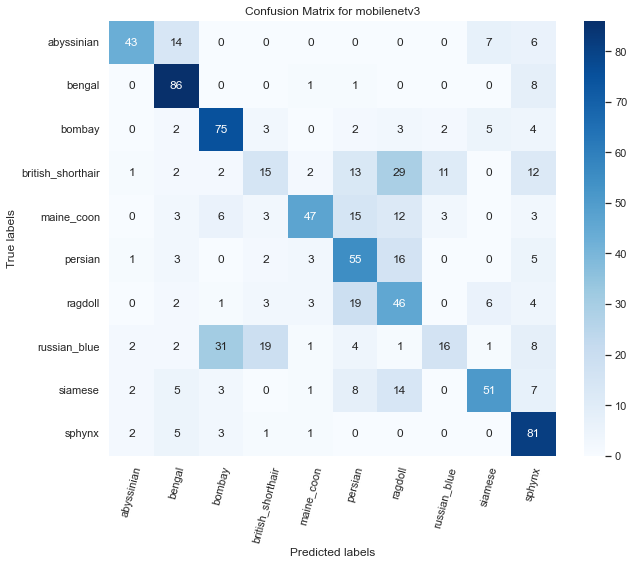

SGD Optimizer - Model: mobilenetv3, Accuracy: 58.59%


  0%|          | 0/55 [00:00<?, ?it/s]

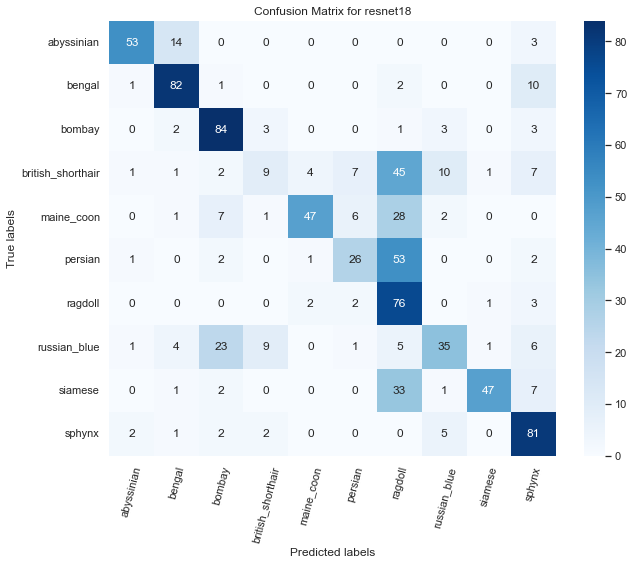

SGD Optimizer - Model: resnet18, Accuracy: 61.43%


  0%|          | 0/55 [00:00<?, ?it/s]

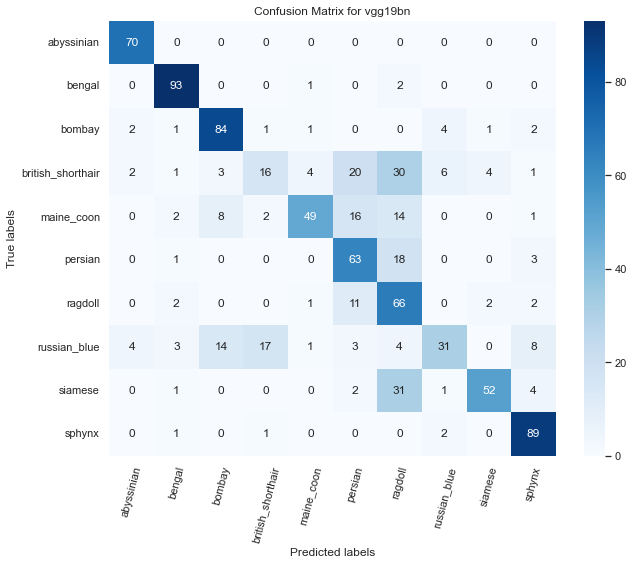

SGD Optimizer - Model: vgg19bn, Accuracy: 69.74%


In [11]:
test_data_scrap_cat = ImageFolder('breed_dataset/cat/')
test_transform = transforms.Compose([
    transforms.Resize((224,224)), 
    transforms.ToTensor(),
])
accuracies_scrap = {}

num_classes = len(class_names)

for model_name in model_names:
    state_dict = torch.load(f"breed_models/cat/adam/{model_name}_best_model.pth")
    model = dog_breed.get_pretrained_model(model_name, num_classes)

    model.load_state_dict(state_dict)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    batch_size = 8
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size * 2)

    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, class_names, model_name)
    
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[model_name] = accuracy
    print(f"Adam Optimizer - Model: {model_name}, Accuracy: {accuracy * 100:.2f}%")

for model_name_sgd in model_names_sgd:
    state_dict_sgd = torch.load(f"breed_models/cat/sgd/{model_name_sgd}_best_model.pth")
    model_sgd = dog_breed.get_pretrained_model(model_name_sgd, num_classes)

    model_sgd.load_state_dict(state_dict_sgd)
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model_sgd.to(device)

    batch_size = 8
    test_dataset_scrap = dog_breed.CatBreedDataset(test_data_scrap_cat, test_transform)
    test_dl_scrap = DataLoader(test_dataset_scrap, batch_size * 2)

    confusion_matrix_all_classes = dog_breed.create_confusion_matrix(model_sgd, test_dl_scrap)
    dog_breed.plot_confusion_matrix(confusion_matrix_all_classes, class_names, model_name_sgd)
    
    total_samples = len(test_dataset_scrap)
    correct_predictions = sum(confusion_matrix_all_classes[i][i] for i in range(len(confusion_matrix_all_classes)))
    accuracy = correct_predictions / total_samples
    accuracies_scrap[f'{model_name_sgd}_sgd'] = accuracy
    print(f"SGD Optimizer - Model: {model_name_sgd}, Accuracy: {accuracy * 100:.2f}%")





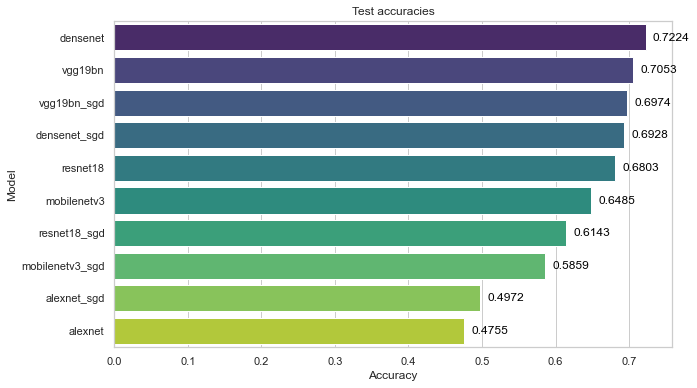

In [12]:
last_accuracies = [accuracies for accuracies in accuracies_scrap.values()]
models = list(accuracies_scrap.keys())

sorted_data = sorted(zip(last_accuracies, models), reverse=True)
sorted_accuracies, sorted_models = zip(*sorted_data)

plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")

ax = sns.barplot(x=list(sorted_accuracies), y=list(sorted_models), palette='viridis')

for i, v in enumerate(sorted_accuracies):
    ax.text(v + 0.01, i, f'{v:.4f}', color='black', va='center')

plt.title('Test accuracies')
plt.xlabel('Accuracy')
plt.ylabel('Model')
plt.show()
